In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import shutil
import  opennmt.inputters.record_inputter as inpu
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import time
import torch.utils.data as data
from torch import nn
from PIL import Image
import os
import os.path
import random
import torch.nn.functional as F

In [2]:
class I(torch.nn.Module):
    def __init__(self):
        super(I, self).__init__()
        
    def forward(self, x):
        return x
    
    def extra_repr(self):
        return 'identity'


class GradReverse(torch.autograd.Function):
    def __init__(self, lambd):
        self.lambd = lambd

    def forward(self, x):
        return x # x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -1 * self.lambd)

def reverse_grad(x,lambd):
    return GradReverse(lambd)(x)

class SignClfDA(torch.nn.Module):
    def __init__(self,mode=1):
        super(SignClfDA, self).__init__()
        if mode==1:
            self.model = torchvision.models.inception_v3(pretrained=True)
            self.model.aux_logits = False
            num_units = 2048
        else:
            self.model = torchvision.models.resnet18(pretrained=True)
            num_units = 512
        self.model.fc = I()

        self.fc_out = torch.nn.Linear(in_features=num_units, out_features=45)
        self.fc_da_out = torch.nn.Linear(in_features=num_units, out_features=num_units//2)
        self.fc_da_out2 = torch.nn.Linear(in_features=num_units//2, out_features=2)
        self.lambd = 0
    
    def set_lambda(self, lambd):
        self.lambd = lambd
        
    def forward(self, x):
        x = self.model(x)
        out = self.fc_out(x)
        nx = reverse_grad(x,self.lambd)
        da_out = self.fc_da_out(nx)
        da_out = F.relu(da_out)
        da_out = self.fc_da_out2(da_out)
        return out,da_out
    
    def get_feature(self,x):
        x = self.model(x)
        return x

In [3]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [4]:
class ImageFilelist(data.Dataset):
    def __init__(self, image_list, transform=None):
        self.imgs = image_list
        self.transform = transform

    def __getitem__(self, index):
        impath, target,domain = self.imgs[index]
        img = self.img_loader(impath)
        if self.transform is not None:
            img = self.transform(img)
        return img, target ,domain

    def __len__(self):
        return len(self.imgs)
    
    def img_loader(self,path):
        return Image.open(path).convert('RGB')

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updat

In [6]:
def make_weights_for_balanced_classes(images, nclasses,power=1,threshold=None, w=None):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1
    weight_per_class = np.zeros(nclasses)       
    N = float(sum(count))                                                   
    for i in range(nclasses):
        if count[i] != 0:
            weight_per_class[i] = N/float(count[i])
    weight_per_class = np.array(weight_per_class)**power
    if threshold is not None:
        weight_per_class /= weight_per_class[weight_per_class!=0].min()
        weight_per_class = np.clip(weight_per_class,a_max=threshold,a_min=0)
        print(weight_per_class)
    if w is not None:
        weight_per_class = w
        print(weight_per_class)
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight , weight_per_class

In [7]:
img_size = 302
trans_train = transforms.Compose([
    #torchvision.transforms.RandomResizedCrop(img_size,scale=(0.75,1)),
    #torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size-3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size-3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
batch_size = 32
test_batch_size= batch_size * 4
junk=False

In [19]:
data_list = []
other_list = []
f = open('1miohands-v2-trainingalignment.txt')
count = 0
counts = [0] * 61
for i,l in enumerate(f.readlines()):
    if i < 799006:
        domain = 0
        path,label = l.split()
        my_path = path.split('/')
        my_path = os.path.join(*my_path[-3:])
        label = int(float(label))
        if label or 1:
            other_list.append((my_path,label,domain))
    else:
        domain = 1
        path,label = l.split()
        my_path = path.split('/')
        my_path = os.path.join(*my_path[-3:])
        label = int(float(label))
        if label or junk:
            data_list.append((my_path,label,domain))
f.close()

In [20]:
test_list = list()
f = open('3359-ph2014-MS-handshape-index.txt')
for l in f.readlines():
    path,label = l.split()
    test_list.append((path,int(float(label)),0))
f.close()

In [21]:
random.shuffle(data_list)
data_size = len(data_list)
dev_size = round(data_size * 0.10)
dev_list = data_list[:dev_size]
train_list = data_list[dev_size:]

In [23]:
train_data = ImageFilelist(image_list=train_list, transform=trans_train)
test_data = ImageFilelist(image_list=test_list, transform=trans_test)
dev_data = ImageFilelist(image_list=dev_list, transform=trans_test)

weights, w= make_weights_for_balanced_classes(train_list, 61,threshold=60, power=0.5)  
weights = torch.DoubleTensor(np.array(weights))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = sampler,num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size,num_workers=8)
dev_loader = torch.utils.data.DataLoader(dev_data,batch_size=test_batch_size,num_workers=8)

[  0.           1.49238377   2.02782279   3.24945929   0.           3.96557436
   1.26244842   3.89274723   4.93022379   3.99188028   1.75117179
   1.3252475    3.07627026   1.03264821   2.36103902   6.76926632
  21.35527146   2.54724997  60.           8.24147959   1.43051303
  19.9760273    5.8379663    9.73764767   3.49507671   2.55070855
   7.68877649  60.           3.37255234   3.90512484   5.96676047
   3.40094474  56.50073746   8.45400197   9.98801365   2.64588945   1.
   6.9026637    2.81450221   5.01362972   2.16670437   5.51390738
   1.87953313   3.41541251   7.27403617   1.55749324   1.39419481
   2.96280022   9.88556978   2.15459243  10.87357199   3.21248239  60.
   6.93726374   4.23094961   1.58461732   2.96551963  60.          14.7532739
   0.          14.92383765]


In [24]:
other_data = ImageFilelist(image_list=other_list, transform=trans_train)
other_loader = torch.utils.data.DataLoader(other_data,batch_size=batch_size, shuffle=True,num_workers=8)

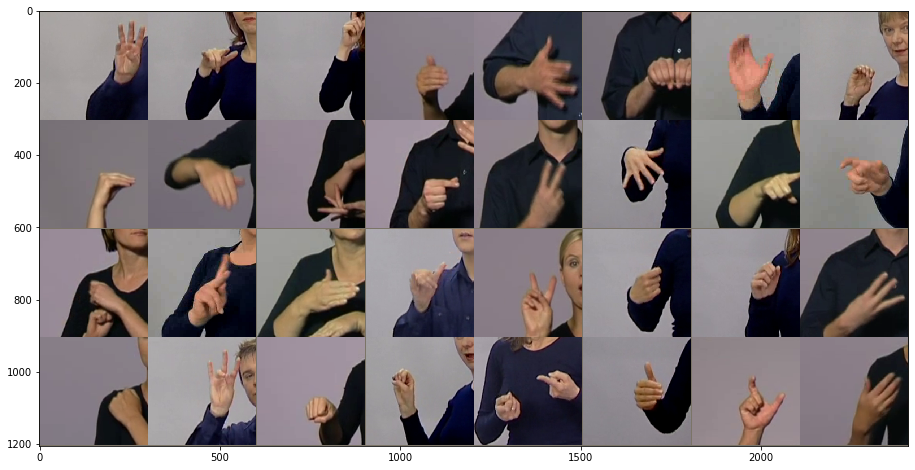

In [25]:
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes,_ = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs);

imshow(out)

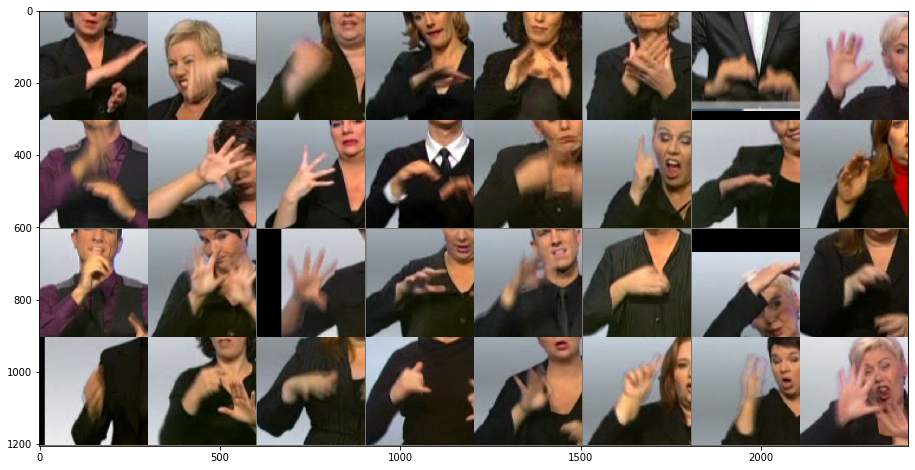

In [26]:
# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes,_ = next(iter(other_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

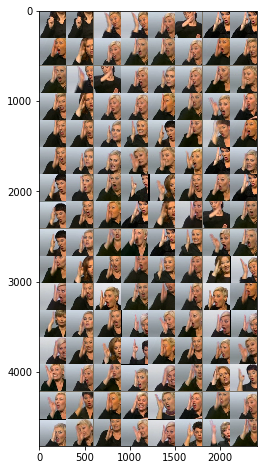

In [27]:
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes,_ = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [28]:
device=torch.device("cuda:0")

In [29]:
model = SignClfDA(mode=1)
model.to(device)
model.train()
print('model created')

model created


In [30]:
iter_num = round(len(train_data) / batch_size)

In [31]:
crit = torch.nn.CrossEntropyLoss()
da_crit = torch.nn.CrossEntropyLoss()
da_crit2 = torch.nn.CrossEntropyLoss()
lr = 5e-3
optimizer = torch.optim.SGD(lr=lr,params=model.parameters(),momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=1,gamma=0.7)

In [32]:
best_acc = 0
da_step = 0
alpha = 0
check_step = 500
inner_step = 4

In [ ]:
for epoch in range(1,100):
    model.train()
    scheduler.step()
    epoch_loss = 0
    epoch_da_loss = 0
    epoch_da_loss2 = 0
    start = time.time()
    it = iter(train_loader)
    check_count = 0
    #####################
    for i in range(iter_num):
        #######################
        optimizer.zero_grad()
        x,y ,d = it.next()
        logits,logits_d  = model(x.to(device))
        loss = crit(logits,y.to(device))
        da_loss = da_crit(logits_d, d.to(device))
        epoch_loss += loss.item()
        ######################################
        other_x,_,other_d = iter(other_loader).next()
        _, other_logits = model(other_x.to(device))
        da_loss2 = da_crit2(other_logits,other_d.to(device))
        epoch_da_loss += da_loss.item()
        epoch_da_loss2 += da_loss2.item()
        ######################################
        train_acc = (logits.argmax(dim=1) == y.to(device)).sum()
        total_loss = loss + (da_loss + da_loss2) 
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
        optimizer.step()
        check_count += 1
        print(i,iter_num,epoch_loss/check_count,epoch_da_loss/check_count,epoch_da_loss2/check_count,end='\r')
        #print(i,iter_num,epoch_loss/check_count,train_acc.cpu().detach().numpy()*100.0/batch_size,end='\r')
        if (i+1) % (iter_num // inner_step) == 0:
            epoch_loss = 0
            epoch_da_loss = 0
            epoch_da_loss2 = 0
            check_count = 0
            da_step += 1
            alpha = 0.25 *  ((2/(1+ np.exp(-10*da_step/(inner_step*10)))) -1)
            model.set_lambda(alpha)
            print('Alpha:',model.lambd)
            model.eval()
            acc = 0
            for ti,(x,y,_) in enumerate(dev_loader):
                with torch.no_grad():
                    logits,_ = model(x.to(device))
                preds = logits.argmax(dim=1)
                print(ti/len(dev_loader),end='\r')
                acc += (preds == y.to(device)).sum()
            print('Dev Accuracy:',acc.cpu().detach().numpy()*100.0/len(dev_data),scheduler.get_lr())
            torch.save(model, 'best_model'+str(da_step)+'.pth')
            acc = 0
            for ti,(x,y,_) in enumerate(test_loader):
                with torch.no_grad():
                    logits,_ = model(x.to(device))
                preds = logits.argmax(dim=1)
                print(ti/len(test_loader),end='\r')
                acc += (preds == y.to(device)).sum()
            print('Test Accuracy:',acc.cpu().detach().numpy()*100.0/len(test_data),scheduler.get_lr())
            model.train()

    print('----------------------'+str(epoch)+'------------------------')
    print('------------------------------------------------')
    print('Loss:',epoch_loss/iter_num,scheduler.get_lr()[0])
    print('Elasped Time:', round(time.time()-start))
    start = time.time()
    print('------------------------------------------------')
